# Análise Espectroscópica

Este notebook segue as melhores práticas da literatura para análise espectroscópica robusta, incluindo:
- Cross Validation
- Remoção de outliers espectrais (PCA, T²/Q)
- Remoção de outliers dos atributos (boxplot + seaborn)
- Teste de todos os filtros (dependentes e independentes de y)
- Modelagem com PLSR, PCR, RFR, SVMR (hiperparâmetros da literatura)
- Plotagens robustas e salvamento de métricas

## 1. Imports

In [1]:
# Imports necessários
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.mlab import detrend
import pywt
from sklearn.pipeline import Pipeline

# Cria diretórios para organizar todas as imagens salvas
print("Criando diretórios para salvar os gráficos...")
os.makedirs('graficos_outliers_pca', exist_ok=True)
os.makedirs('graficos_outliers_boxplot', exist_ok=True)
os.makedirs('modelos_salvos', exist_ok=True)
os.makedirs('graficos_modelos', exist_ok=True) 
os.makedirs('graficos_mlpr', exist_ok=True)

warnings.filterwarnings('ignore')

# Configurações de plot
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

Criando diretórios para salvar os gráficos...


## 2. Carregamento dos Dados

O primeiro passo em qualquer projeto de ciência de dados é carregar e entender os dados. Nesta seção, realizamos as seguintes ações:
- **Carregamento:** Utilizamos a biblioteca `pandas` para ler o arquivo `Avaliacao_Maturacao_Palmer_e_Tommy_Fieldspec.xlsx`, que contém os dados espectrais e os valores de referência (atributos físico-químicos).
- **Separação de Dados:** A função `load_data` inteligentemente separa o arquivo em duas partes:
    - `metadata`: Um DataFrame contendo as informações de referência (ex: Firmness, Dry Mass, TSS, TA, AA), que serão nossas variáveis-alvo (y).
    - `wavelengths`: Um DataFrame contendo a resposta espectral (absorbância ou reflectância) em cada comprimento de onda, que serão nossas variáveis preditoras (X).
- **Definição de Variáveis:** Convertemos os dados espectrais para um array NumPy (`X`) para otimizar os cálculos e definimos a lista de `atributos` que desejamos modelar.

In [2]:
# Função para carregar dados
def load_data(filepath):
    """Carrega dados espectrais e separa metadados de espectros."""
    df = pd.read_excel(filepath, engine='openpyxl')
    
    # Identificar colunas que são comprimentos de onda (numéricas)
    numeric_cols = []
    for col in df.columns:
        try:
            float(col)
            numeric_cols.append(col)
        except ValueError:
            continue
    
    # Separar metadados e comprimentos de onda
    metadata = df.drop(columns=numeric_cols)
    wavelengths = df[numeric_cols]
    
    return metadata, wavelengths

# Carregar dados
filepath = '../Data/Espectroscopia_Bioquimico.xlsx'
metadata, wavelengths = load_data(filepath)
X = wavelengths.values
wavelength_values = wavelengths.columns.astype(float)

# SEM O FIRMNESS -- ESTÁ EM RESULTADOS PARCIAIS
atributos = [ 'Chl_a', 'Chl_b', 'RWC'] 

print(f'Dados carregados: {X.shape[0]} amostras, {X.shape[1]} comprimentos de onda')
print(f'Faixa espectral: {wavelength_values.min():.1f} - {wavelength_values.max():.1f} nm')
print(f'Atributos disponíveis: {list(metadata.columns)}')
print(f'Atributos a analisar: {atributos}')

# remoção de NaN antes de passar pelo pré-processamento e conferência

dados_completos = {}
for atributo in atributos:
    y = metadata[atributo].values
    original_indices = np.arange(len(y))
    
    # Remove apenas valores NaN
    mask = ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]
    original_indices_clean = original_indices[mask]
    
    dados_completos[atributo] = {
        'X': X_clean,
        'y': y_clean,
        'indices_orig': original_indices_clean
    }
    
    print(f'{atributo}: {X_clean.shape[0]} amostras válidas')

print(f'\nPreparação dos dados concluída para {len(atributos)} atributos!')


Dados carregados: 300 amostras, 2151 comprimentos de onda
Faixa espectral: 350.0 - 2500.0 nm
Atributos disponíveis: ['Wavelength', 'Stage', 'Chl_a', 'Chl_b', 'RWC']
Atributos a analisar: ['Chl_a', 'Chl_b', 'RWC']
Chl_a: 300 amostras válidas
Chl_b: 300 amostras válidas
RWC: 300 amostras válidas

Preparação dos dados concluída para 3 atributos!


## 3. Filtros de Pré-processamento (Independentes e Dependentes de y)

Os dados espectrais brutos contêm diversas fontes de variação indesejada que podem mascarar a informação química relevante. Essas variações podem ser causadas por espalhamento de luz (efeitos físicos da amostra), mudanças na linha de base (drift do instrumento) e ruído. O pré-processing visa minimizar esses efeitos para que o modelo foque na correlação entre o espectro e o atributo de interesse.

Neste notebook, testamos uma ampla gama de filtros, divididos em duas categorias:

### Filtros Independentes de y

São aplicados apenas aos espectros (`X`) e não utilizam a informação da variável alvo (`y`).

-   **`Raw`**: Utiliza os dados espectrais brutos, sem nenhum tratamento. Serve como uma linha de base para comparar a eficácia dos outros filtros.
-   **`MSC` (Multiplicative Scatter Correction)**: Corrige o espalhamento de luz (aditivo e multiplicativo) causado por variações no tamanho de partícula e compactação da amostra. Ele ajusta cada espectro para se parecer mais com um espectro "ideal" (geralmente a média de todos os espectros).
-   **`SNV` (Standard Normal Variate)**: Alternativa ao MSC que também corrige o espalhamento de luz. A diferença é que o SNV padroniza cada espectro individualmente (subtrai a média e divide pelo desvio padrão daquele espectro), sem usar um espectro de referência.
-   **`SG_D1` e `SG_D2` (Savitzky-Golay Derivatives)**: Calcula a primeira ou a segunda derivada do espectro. Derivadas são excelentes para remover desvios de linha de base (efeitos aditivos) e para resolver picos espectrais sobrepostos, realçando a informação de bandas de absorção específicas.
-   **`Detrend`**: Remove tendências lineares ou polinomiais da linha de base do espectro. É muito eficaz para corrigir "inclinações" no espectro causadas por drift do instrumento.
-   **`Normalize`**: Realiza uma normalização Min-Max, escalonando a intensidade de cada espectro para um intervalo fixo (geralmente [0, 1]). Ajuda a corrigir variações de intensidade causadas por diferenças na distância da amostra ou na potência da fonte de luz.
-   **`EMSC` (Extended Multiplicative Signal Correction)**: Uma versão avançada do MSC. Além de corrigir os efeitos de espalhamento, o EMSC pode incluir termos polinomiais para modelar e remover efeitos de linha de base mais complexos e não-lineares.
-   **`Continuum Removal`**: Técnica que normaliza os espectros para que as bandas de absorção possam ser comparadas em termos de sua profundidade, e não de sua intensidade absoluta. Ele ajusta um "envelope" (casco convexo) sobre o espectro e divide o espectro original por este envelope, realçando as características de absorção.
-   **`Wavelet_Denoising`**: Utiliza a Transformada Wavelet para decompor o espectro em diferentes níveis de frequência. A técnica permite remover o ruído (geralmente presente em altas frequências) de forma muito eficaz, preservando as principais características do sinal espectral.

### Filtros Dependentes de y e Combinações

Estes filtros utilizam a variável alvo (`y`) para otimizar a remoção de variação não correlacionada em `X`, ou são combinações sequenciais de múltiplos filtros para um tratamento mais completo.

-   **`OSC_1` e `OSC_2` (Orthogonal Signal Correction)**: Filtro que remove componentes (1 ou 2, neste caso) dos espectros `X` que são ortogonais (não correlacionados) à variável alvo `y`. O objetivo é limpar `X` da variação que não ajuda na predição, potencialmente melhorando o modelo subsequente. Esta técnica é frequentemente referida como um pré-processamento **OPLS** (Orthogonal Projections to Latent Structures).
-   **`MSC_SG_OSC`**: Uma **cadeia de pré-processamentos** aplicada na seguinte ordem:
    1.  `MSC` para corrigir o espalhamento.
    2.  `Savitzky-Golay (1ª derivada)` para corrigir a linha de base.
    3.  `OSC (1 componente)` para remover variação não correlacionada com `y`.
-   **`OPLS1_SNV_SG_D1` e `OPLS2_SNV_SG_D1`**: Outra cadeia de processamento:
    1.  `SNV` para correção de espalhamento.
    2.  `Savitzky-Golay (1ª derivada)`.
    3.  `OPLS/OSC` para remover 1 ou 2 componentes ortogonais a `y`.
-   **`SNV_Detrend_SG_D1`**: Uma combinação de filtros independentes de `y`, mas que, por sua complexidade, é testada junto às outras cadeias:
    1.  `SNV`.
    2.  `Detrend` para remoção de tendência.
    3.  `Savitzky-Golay (1ª derivada)`.

In [3]:
# Implementação dos filtros de pré-processamento
# Filtros independentes de y

def msc(X):
    """Multiplicative Scatter Correction."""
    X = np.asarray(X)
    mean_spectrum = np.mean(X, axis=0)
    corrected_spectra = np.zeros_like(X)
    for i in range(X.shape[0]):
        slope, intercept = np.polyfit(mean_spectrum, X[i, :], 1)
        corrected_spectra[i, :] = (X[i, :] - intercept) / slope
    return corrected_spectra

def snv(X):
    """Standard Normal Variate."""
    X = np.asarray(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

def savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1):
    """Savitzky-Golay filter."""
    return savgol_filter(X, window_length=window_size, polyorder=poly_order, deriv=deriv_order, axis=1)

def detrend_filter(X):
    """Detrending filter."""
    return detrend(X, axis=1)

def normalize(X):
    """Normalização Min-Max."""
    return (X - np.min(X, axis=1, keepdims=True)) / (np.max(X, axis=1, keepdims=True) - np.min(X, axis=1, keepdims=True))

def emsc(X, reference=None):
    """Extended Multiplicative Signal Correction."""
    X = np.asarray(X)
    if reference is None:
        reference = np.mean(X, axis=0)  # Usa o espectro médio como referência
    
    X_corr = np.zeros_like(X)
    for i in range(X.shape[0]):
        # Modelo: X[i] ≈ a + b*reference
        model = np.vstack([np.ones_like(reference), reference]).T
        params, _, _, _ = np.linalg.lstsq(model, X[i, :], rcond=None)
        a, b = params[0], params[1]
        X_corr[i,:] = (X[i, :] - a) / b
    return X_corr

def continuum_removal(X, wavelengths):
    """Continuum Removal."""
    X = np.asarray(X)
    X_cr = np.zeros_like(X)
    for i in range(X.shape[0]):
        spectrum = X[i, :]
        # Encontra os pontos do casco convexo superior
        q_u = [0]
        for k in range(1, len(wavelengths) - 1):
            s_k = (spectrum[len(wavelengths)-1] - spectrum[0]) / (wavelengths[-1] - wavelengths[0])
            s_q = (spectrum[k] - spectrum[q_u[-1]]) / (wavelengths[k] - wavelengths[q_u[-1]])
            if s_q > s_k:
                q_u.append(k)
        q_u.append(len(wavelengths)-1)
        
        # Interpolação linear entre os pontos do casco
        continuum = np.interp(wavelengths, wavelengths[q_u], spectrum[q_u])
        X_cr[i, :] = spectrum / continuum
    return X_cr

def wavelet_denoising(X, wavelet='db4', level=4):
    """Wavelet Transform para Denoising."""
    X = np.asarray(X)
    original_length = X.shape[1]
    denoised_list = []

    for i in range(X.shape[0]):
        # 1. Decomposição Wavelet
        coeffs = pywt.wavedec(X[i, :], wavelet, level=level)

        # 2. Cálculo do limiar (threshold)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(original_length))

        # 3. Aplicação do filtro (soft thresholding) nos coeficientes de detalhe
        coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]

        # 4. Reconstrução do sinal
        reconstructed_signal = pywt.waverec(coeffs, wavelet)

        # 5. Ajuste do tamanho
        denoised_list.append(reconstructed_signal[:original_length])

    return np.asarray(denoised_list)

# Filtros dependentes de y (Orthogonal Signal Correction)
class OrthogonalCorrection:
    """Orthogonal Signal Correction (OSC)."""
    def __init__(self, n_components=1):
        self.n_components = n_components
    
    def fit_transform(self, X, y):
        X, y = np.asarray(X), np.asarray(y).ravel()
        self.w_ortho_ = []
        self.p_ortho_ = []
        self.X_corr_ = X.copy()
        
        for _ in range(self.n_components):
            pls = PLSRegression(n_components=1)
            pls.fit(self.X_corr_, y)
            t = pls.x_scores_
            w = pls.x_weights_
            p = pls.x_loadings_
            
            # Componente Ortogonal
            w_ortho = p - (np.dot(w.T, p) / np.dot(w.T, w)) * w
            t_ortho = np.dot(self.X_corr_, w_ortho)
            p_ortho = np.dot(t_ortho.T, self.X_corr_) / np.dot(t_ortho.T, t_ortho)
            
            # Remover variação ortogonal
            self.X_corr_ -= np.dot(t_ortho, p_ortho)
            self.w_ortho_.append(w_ortho)
            self.p_ortho_.append(p_ortho)
        
        return self.X_corr_
    
    def transform(self, X):
        X_res = np.asarray(X).copy()
        for i in range(self.n_components):
            t_ortho = np.dot(X_res, self.w_ortho_[i])
            X_res -= np.dot(t_ortho, self.p_ortho_[i])
        return X_res

# Dicionário de filtros independentes de y
filtros_independentes = {
    'Raw': lambda X: X,
    'MSC': msc,
    'SNV': snv,
    'SG_D1': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1),
    'SG_D2': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=2),
    'Detrend': detrend_filter,
    'Normalize': normalize,
    'EMSC': emsc,
    'Continuum_Removal': lambda X: continuum_removal(X, wavelength_values),
    'Wavelet_Denoising': wavelet_denoising
}

# Dicionário de filtros dependentes de y
filtros_dependentes = {
    'OSC_1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(X, y),
    'OSC_2': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(X, y),
    'MSC_SG_OSC': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(msc(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS1_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS2_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'SNV_Detrend_SG_D1': lambda X, y: savitzky_golay(detrend_filter(snv(X)), window_size=11, poly_order=2, deriv_order=1)
}

print(f'Filtros independentes de y: {list(filtros_independentes.keys())}')
print(f'Filtros dependentes de y: {list(filtros_dependentes.keys())}')
print(f'Total de filtros: {len(filtros_independentes) + len(filtros_dependentes)}')

Filtros independentes de y: ['Raw', 'MSC', 'SNV', 'SG_D1', 'SG_D2', 'Detrend', 'Normalize', 'EMSC', 'Continuum_Removal', 'Wavelet_Denoising']
Filtros dependentes de y: ['OSC_1', 'OSC_2', 'MSC_SG_OSC', 'OPLS1_SNV_SG_D1', 'OPLS2_SNV_SG_D1', 'SNV_Detrend_SG_D1']
Total de filtros: 16


## 4. Remoção de Outliers Espectrais (PCA, T²/Q)

Outliers espectrais são amostras cujo espectro é muito diferente do resto da população, podendo ser causados por erros de medição, contaminação ou características únicas da amostra. Eles podem prejudicar significativamente a capacidade de generalização do modelo.
- **Método PCA (T²/Q):** Usamos a Análise de Componentes Principais (PCA) para identificar esses outliers.
    - **Estatística T² (Hotelling's T²):** Mede a variação de uma amostra *dentro* do modelo PCA. Valores altos indicam que a amostra é um outlier na combinação das variáveis principais.
    - **Estatística Q (Resíduos):** Mede a variação da amostra *fora* do modelo PCA (o que o modelo não conseguiu capturar). Valores altos indicam que a estrutura do espectro da amostra é anormal.
- **Lógica:** Uma amostra é considerada outlier se seu valor de T² ou Q ultrapassa um limite de confiança (geralmente 3 desvios padrão da média).
- **Importante:** A remoção de outliers é feita **apenas no conjunto de calibração**. O conjunto de validação deve permanecer intacto para simular dados "reais" que o modelo encontrará no futuro.

In [4]:
def pca_outlier_removal(X, n_components=10, threshold=3):
    """Remove outliers usando PCA com estatísticas T² e Q."""
    # Padronizar dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calcular estatística T² (Hotelling's T²)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0)) ** 2, axis=1)
    
    # Calcular estatística Q (resíduos)
    X_reconstructed = pca.inverse_transform(X_pca)
    Q = np.sum((X_scaled - X_reconstructed) ** 2, axis=1)
    
    # Definir limites (média + threshold * desvio padrão)
    T2_limit = np.mean(T2) + threshold * np.std(T2)
    Q_limit = np.mean(Q) + threshold * np.std(Q)
    
    # Identificar outliers
    outliers_mask = (T2 > T2_limit) | (Q > Q_limit)
    
    # Retornamos a máscara de quem NÃO é outlier e o modelo PCA treinado
    return ~outliers_mask, pca, T2, Q, T2_limit, Q_limit

dados_pca = {}

#para todo o conjunto de dado e não separado em cal e val
for atributo in atributos:
    X_full = dados_completos[atributo]['X']
    y_full = dados_completos[atributo]['y']
    indices_orig_full = dados_completos[atributo]['indices_orig']
    
    # Chama a função de remoção de outliers espectrais
    keep_mask, pca_model, T2, Q, T2_limit, Q_limit = pca_outlier_removal(X_full)
    
    # Identifica e informa os outliers removidos
    outliers_indices = indices_orig_full[~keep_mask]
    print(f'{atributo}: {len(outliers_indices)} outliers espectrais removidos.')
    if len(outliers_indices) > 0:
        print(f'  Índices Originais Removidos: {outliers_indices}')
    
    # Filtra os dados
    X_clean = X_full[keep_mask]
    y_clean = y_full[keep_mask]
    indices_orig_clean = indices_orig_full[keep_mask]
    
    dados_pca[atributo] = {
        'X': X_clean,
        'y': y_clean,
        'indices_orig': indices_orig_clean,
        'pca_model': pca_model,
        'T2': T2,
        'Q': Q,
        'T2_limit': T2_limit,
        'Q_limit': Q_limit,
        'keep_mask': keep_mask
    }
    
    print(f'  Dataset final: {X_clean.shape[0]} amostras')
    print()


Chl_a: 6 outliers espectrais removidos.
  Índices Originais Removidos: [ 69  85  86 211 270 271]
  Dataset final: 294 amostras

Chl_b: 6 outliers espectrais removidos.
  Índices Originais Removidos: [ 69  85  86 211 270 271]
  Dataset final: 294 amostras

RWC: 6 outliers espectrais removidos.
  Índices Originais Removidos: [ 69  85  86 211 270 271]
  Dataset final: 294 amostras



### 4.1 Gráficos de Outliers T² e Q

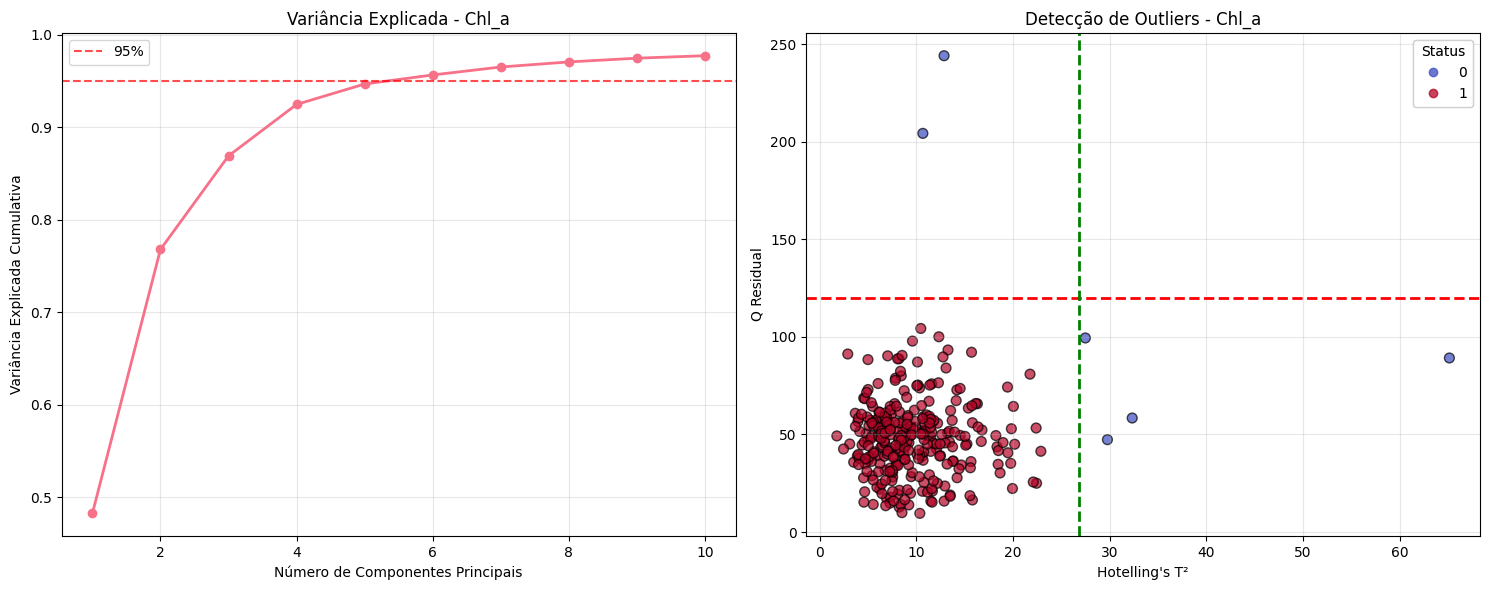

Gráficos de outliers PCA para Chl_a salvos em: graficos_outliers_pca/pca_outliers_Chl_a.png



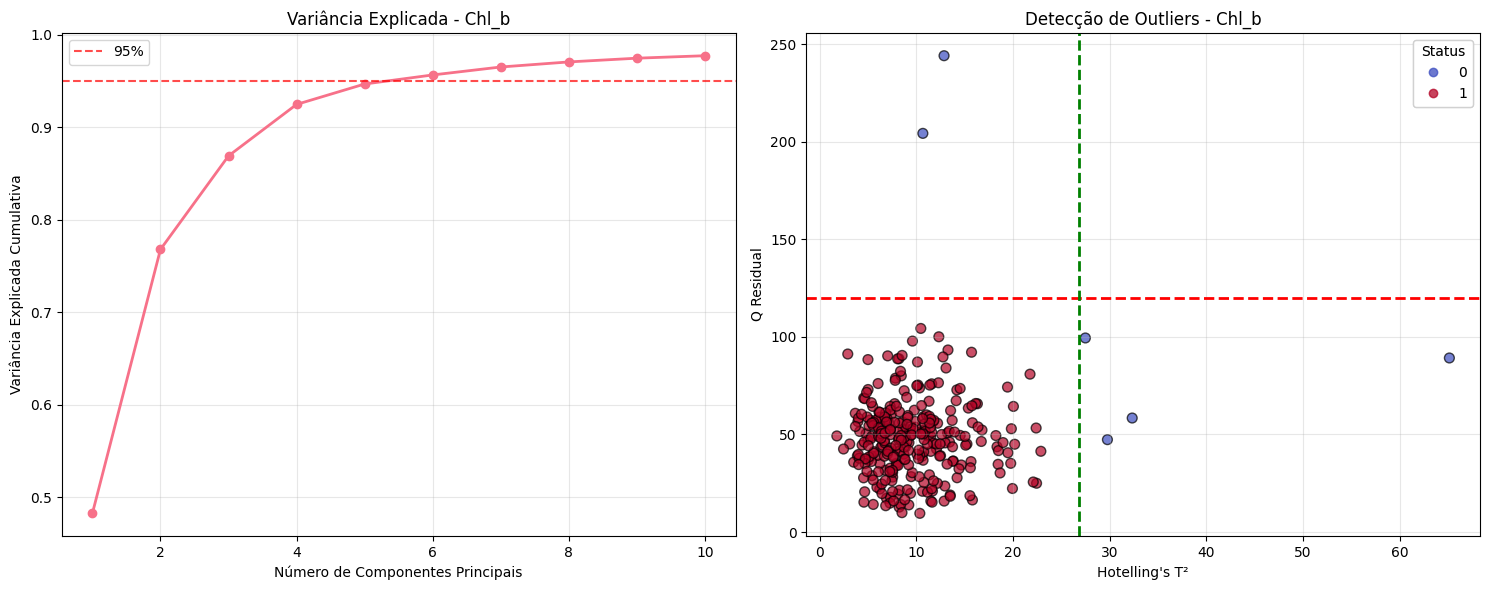

Gráficos de outliers PCA para Chl_b salvos em: graficos_outliers_pca/pca_outliers_Chl_b.png



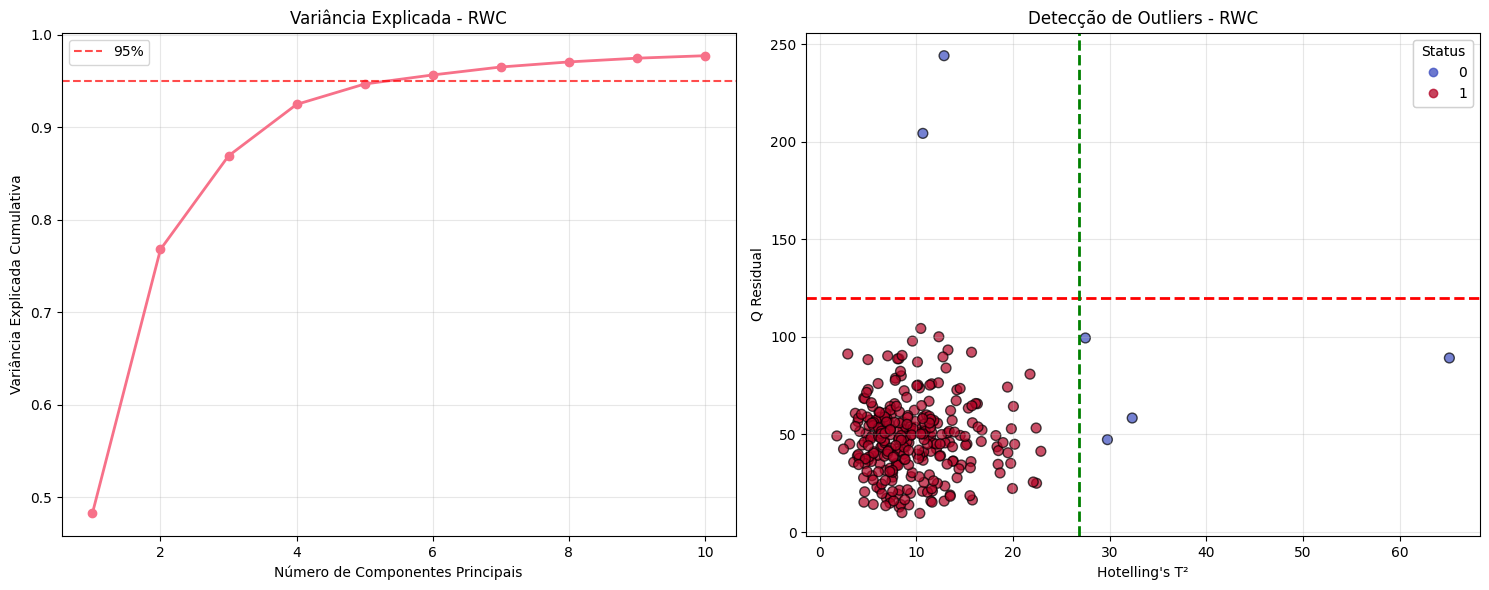

Gráficos de outliers PCA para RWC salvos em: graficos_outliers_pca/pca_outliers_RWC.png



In [5]:
# Plotagem dos gráficos de outliers PCA
for atributo in atributos:
    d = dados_pca[atributo]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Variância explicada cumulativa
    # Acessa o modelo PCA com a chave correta 'pca_model'

    cumulative_variance = np.cumsum(d['pca_model'].explained_variance_ratio_)
    axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', linewidth=2, markersize=6)
    axes[0].set_xlabel('Número de Componentes Principais')
    axes[0].set_ylabel('Variância Explicada Cumulativa')
    axes[0].set_title(f'Variância Explicada - {atributo}')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    axes[0].legend()
    
    # Gráfico 2: T² vs Q (detecção de outliers)
    # Acessa as variáveis T2, Q, T2_limit, Q_limit e keep_mask com as chaves corretas
    scatter = axes[1].scatter(d['T2'], d['Q'], c=d['keep_mask'], cmap='coolwarm', 
                              edgecolor='k', alpha=0.7, s=50)
    axes[1].axhline(d['Q_limit'], color='r', linestyle='--', linewidth=2, label=f'Q Limit: {d["Q_limit"]:.2f}')
    axes[1].axvline(d['T2_limit'], color='g', linestyle='--', linewidth=2, label=f'T² Limit: {d["T2_limit"]:.2f}')
    axes[1].set_xlabel("Hotelling's T²")
    axes[1].set_ylabel('Q Residual')
    axes[1].set_title(f'Detecção de Outliers - {atributo}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Adicionar legenda de cores
    legend1 = axes[1].legend(*scatter.legend_elements(), title="Status")
    axes[1].add_artist(legend1)
    
    plt.tight_layout()
    
    # Salvar gráfico
    nome_arquivo = f'graficos_outliers_pca/pca_outliers_{atributo.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")}.png'
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f'Gráficos de outliers PCA para {atributo} salvos em: {nome_arquivo}')
    print()

## 5. Remoção de Outliers dos Atributos (Boxplot + Seaborn)

Além dos outliers espectrais (em X), podemos ter outliers nos valores de referência (em y). Por exemplo, um valor de pH ou SST que é analiticamente improvável ou resultado de um erro de anotação.
- **Método (IQR):** O método do Intervalo Interquartil (IQR) é uma forma estatística robusta de identificar esses pontos.
    - `IQR = Q3 (percentil 75) - Q1 (percentil 25)`
    - Um valor é considerado outlier se estiver abaixo de `Q1 - 1.5 * IQR` ou acima de `Q3 + 1.5 * IQR`.
- **Visualização:** O `boxplot` é a ferramenta visual perfeita para essa análise, pois ele desenha os "bigodes" exatamente nesses limites de 1.5 * IQR, mostrando os outliers como pontos individuais.
- **Ação:** Novamente, a remoção é feita apenas no conjunto de calibração.

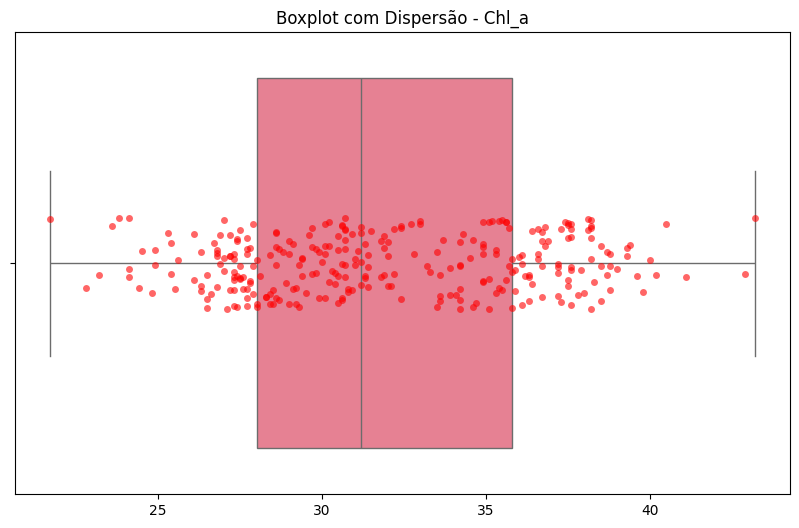

Chl_a: 0 outliers de atributo removidos.
  Dataset final para modelagem: 294 amostras



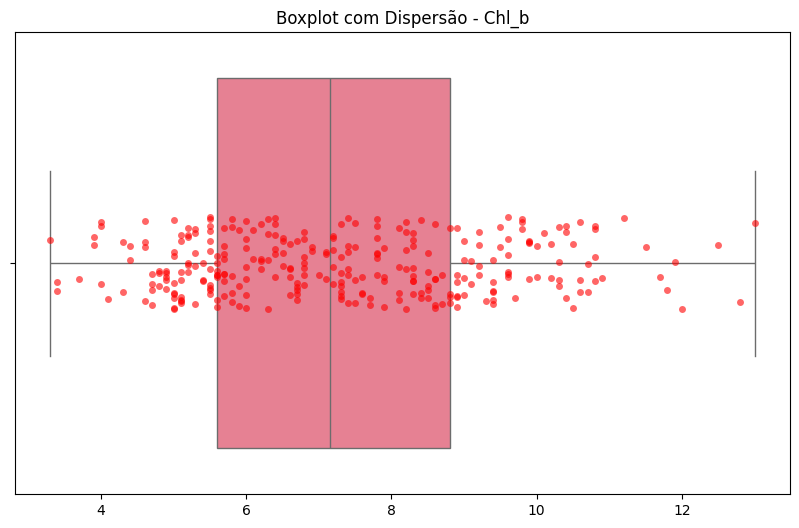

Chl_b: 0 outliers de atributo removidos.
  Dataset final para modelagem: 294 amostras



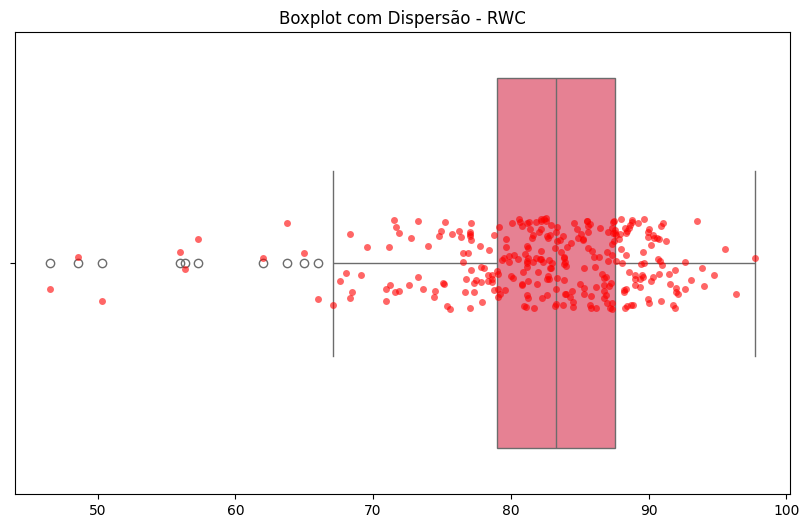

RWC: 10 outliers de atributo removidos.
  Índices Originais Removidos: [  0   1   9  92  97 105 107 197 199 204]
  Dataset final para modelagem: 284 amostras

Remoção de outliers concluída!


In [6]:
# Remover outliers dos atributos usando boxplot e IQR

dados_final = {}

for atributo in atributos:
    # Pega os dados já limpos de outliers espectrais
    d = dados_pca[atributo]
    X_clean = d['X']
    y_clean = d['y']
    indices_orig_clean = d['indices_orig']
    
    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=y_clean)
    sns.stripplot(x=y_clean, color='red', alpha=0.6)
    plt.title(f'Boxplot com Dispersão - {atributo}')
    
    nome_arquivo = f'graficos_outliers_boxplot/boxplot_outliers_{atributo.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")}.png'
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    plt.show()

    # Lógica de remoção de outliers dos atributos
    Q1 = np.percentile(y_clean, 25)
    Q3 = np.percentile(y_clean, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    keep_mask_attr = (y_clean >= lower_bound) & (y_clean <= upper_bound)
    
    # Identifica e informa os outliers removidos
    outliers_attr_indices = indices_orig_clean[~keep_mask_attr]
    print(f'{atributo}: {len(outliers_attr_indices)} outliers de atributo removidos.')
    if len(outliers_attr_indices) > 0:
        print(f'  Índices Originais Removidos: {outliers_attr_indices}')
    
    # Armazena os dados finais e limpos para modelagem
    dados_final[atributo] = {
        'X': X_clean[keep_mask_attr],
        'y': y_clean[keep_mask_attr]
    }
    
    print(f'  Dataset final para modelagem: {dados_final[atributo]["X"].shape[0]} amostras')
    print()

print("Remoção de outliers concluída!")

In [7]:
# --- Função para o Gráfico de CALIBRAÇÃO (Ref vs Predito vs CV) ---
def save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, filtro, modelo, file_path):
    """
    Gera e salva um gráfico comparando predições de treino e de validação cruzada
    no conjunto de calibração.
    """
    try:
        # Garante que o diretório exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Métricas para Predição no Treino Completo
        slope_pred, offset_pred = np.polyfit(y_cal, y_pred_cal, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_cal, y_pred_cal))
        r2_pred = r2_score(y_cal, y_pred_cal)

        # Métricas para Predição da Validação Cruzada
        slope_cv, offset_cv = np.polyfit(y_cal, y_pred_cv, 1)
        rmse_cv = np.sqrt(mean_squared_error(y_cal, y_pred_cv))
        r2_cv = r2_score(y_cal, y_pred_cv)

        plt.figure(figsize=(10, 8))
        plt.scatter(y_cal, y_pred_cal, color='blue', marker='o', alpha=0.6, label=f'Predição no Treino (R²={r2_pred:.3f})')
        plt.scatter(y_cal, y_pred_cv, color='red', marker='x', alpha=0.7, label=f'Predição CV (R²={r2_cv:.3f})')
        
        # Linha ideal 1:1
        min_val = min(min(y_cal), min(y_pred_cal), min(y_pred_cv))
        max_val = max(max(y_cal), max(y_pred_cal), max(y_pred_cv))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Linha Ideal (1:1)')

        plt.xlabel("Valores Reais (Calibração)")
        plt.ylabel("Valores Preditos")
        plt.title(f'Desempenho na Calibração: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='lower right')
        
        # Adiciona texto com métricas
        stats_text = (
            f'Treino - RMSE: {rmse_pred:.3f}, Slope: {slope_pred:.3f}, Offset: {offset_pred:.3f}\n'
            f'CV     - RMSE: {rmse_cv:.3f}, Slope: {slope_cv:.3f}, Offset: {offset_cv:.3f}'
        )
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gráfico de calibração para {modelo} com {filtro}: {e}")
        plt.close()


# --- Função para o Gráfico de VALIDAÇÃO (Predito vs Real) ---
def save_validation_plot(y_val, y_pred_val, atributo, filtro, modelo, file_path):
    """
    Gera e salva o gráfico de predições no conjunto de validação (teste).
    """
    try:
        # Garante que o diretório exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        # Métricas
        r2 = r2_score(y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        slope, offset = np.polyfit(y_val, y_pred_val, 1)

        plt.figure(figsize=(8, 8))
        plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolors='k', label='Dados de Validação')
        
        # Linha ideal 1:1
        min_val = min(min(y_val), min(y_pred_val))
        max_val = max(max(y_val), max(y_pred_val))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Linha Ideal (1:1)')

        plt.xlabel('Valores Reais (Validação)')
        plt.ylabel('Valores Preditos')
        plt.title(f'Desempenho na Validação: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        
        stats_text = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nSlope = {slope:.4f}'
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))
        
        plt.legend()
        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gráfico de validação para {modelo} com {filtro}: {e}")
        plt.close()


## 6. Avaliação dos Filtros e Seleção dos Melhores Modelos com Validação Cruzada

Nesta etapa crucial, construímos e avaliamos os modelos de regressão. Em vez de testar cada modelo separadamente, criamos um fluxo automatizado e exaustivo para garantir que encontremos a melhor performance possível.
- **Estratégia:**
    1. **Iteração por Atributo:** Um loop externo passa por cada variável alvo (AT, PH, etc.).
    2. **Iteração por Modelo:** Para cada atributo, testamos uma lista de modelos quimiométricos:
        - `PLSR`: Padrão da área, lida bem com multicolinearidade.
        - `PCR`: Alternativa que primeiro reduz a dimensionalidade.
        - `RFR` (Random Forest): Modelo não-linear, robusto e poderoso.
        - `SVMR` (Support Vector Machine): Eficaz em espaços de alta dimensão.
    3. **Iteração por Filtro:** Para cada modelo, aplicamos **todos os 16 filtros** de pré-processamento definidos na seção anterior.
    4. **Otimização (GridSearchCV):** Para cada combinação `(atributo, modelo, filtro)`, usamos `GridSearchCV` com validação cruzada (10-fold) para encontrar os melhores hiperparâmetros do modelo (ex: número de componentes para PLS, parâmetros C e gamma para SVM).
- **Avaliação:** O desempenho de cada combinação é medido pelo R² da validação cruzada. O melhor modelo é então treinado com todos os dados de calibração e sua performance final é avaliada no conjunto de validação, que foi mantido separado durante todo o processo.
- **Saídas:** Ao final, teremos os resultados de centenas de modelos, permitindo uma comparação justa e a seleção do campeão para cada atributo. Todos os gráficos de predição e as métricas são salvos automaticamente.

In [8]:

def save_calibration_plot_cv(y_true, y_pred_cv, atributo, filtro, modelo, file_path):
 
    try:
        # Garante que o diretório exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Métricas para Predição da Validação Cruzada
        slope_cv, offset_cv = np.polyfit(y_true, y_pred_cv, 1)
        rmse_cv = np.sqrt(mean_squared_error(y_true, y_pred_cv))
        r2_cv = r2_score(y_true, y_pred_cv)

        plt.figure(figsize=(10, 8))
        plt.scatter(y_true, y_pred_cv, color='blue', marker='o', alpha=0.7, label=f'Cross-Validation (R²={r2_cv:.3f})')
        
        # Linha ideal 1:1
        min_val = min(min(y_true), min(y_pred_cv))
        max_val = max(max(y_true), max(y_pred_cv))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Linha Ideal (1:1)')

        plt.xlabel("Valores Reais")
        plt.ylabel("Valores Preditos (CV)")
        plt.title(f'Cross-Validation: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='lower right')
        
        # Adiciona texto com métricas
        stats_text = f'CV - R²: {r2_cv:.3f}, RMSE: {rmse_cv:.3f}, Slope: {slope_cv:.3f}, Offset: {offset_cv:.3f}'
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gráfico de CV para {modelo} com {filtro}: {e}")
        plt.close()

### 6.1 Modelos e Grids de Parâmetros

In [9]:
import re


modelos = {
    'PLSR': {
        'estimador': PLSRegression(),
        'params': {'n_components': [5, 10, 15, 20]}
    },
    'PCR': {
        'estimador': Pipeline([('pca', PCA()), ('regressor', LinearRegression())]),
        'params': {'pca__n_components': [5, 10, 15, 20]}
    },
        'SVMR': {
        'estimador': SVR(),
        'params': {
          'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'kernel': ['rbf', 'linear'],
            'epsilon': [0.1, 0.2, 0.5, 1.0]
        }
    },
#     'RFR': {
#        'estimador': RandomForestRegressor(random_state=42),
#        'params': {
#            'n_estimators': [100, 150, 200, 250, 300],
#            'max_depth': [10, 20, 30, None],
#            'min_samples_split': [2, 5, 10],
#            'min_samples_leaf': [1, 2, 4],
#            'warm_start': [True, False],
#            'bootstrap': [True, False]
#        }
#     }
    
}

# Combina todos os filtros
todos_filtros = {**filtros_independentes, **filtros_dependentes}

# Lista para armazenar todos os resultados
lista_resultados_finais = []

#AQUI COMEÇA O CROSS VALIDATION -- PRINCIPAIS ALTERAÇÕES DO CÓDIGO DE ANDRESSA

cv_folds = 10  # Número de folds para cross-validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

for atributo in atributos: 
    print(f'\n{"="*30}')
    print(f'INICIANDO MODELAGEM PARA: {atributo}')
    print(f'{"="*30}')

    melhor_r2_atributo = -999  # Inicia com um valor muito baixo
    melhor_combinacao_info = {}  # Dicionário para guardar as infos do melhor
    
    # Dicionário para armazenar as 5 melhores combinações por modelo
    melhores_por_modelo = {nome: [] for nome in modelos.keys()}

    dados = dados_final[atributo]
    X_full, y_full = dados['X'], dados['y']

    for nome_modelo, info_modelo in modelos.items():
        print(f'\n--- Modelo: {nome_modelo} ---')
        
        combinacoes_deste_modelo = [] # Lista temporária para este modelo

        for nome_filtro, funcao_filtro in todos_filtros.items():
            start_time = time.time()
            print(f'  Testando filtro: {nome_filtro}...', end='')

            if nome_filtro in filtros_independentes:
                X_filtered = funcao_filtro(X_full)
                tipo_filtro = 'independente'
            else:  # Filtro dependente de Y
                X_filtered = funcao_filtro(X_full, y_full)
                tipo_filtro = 'dependente'
            
            grid = GridSearchCV(
                info_modelo['estimador'], 
                info_modelo['params'], 
                cv=kf,  # Usa o mesmo KFold para consistência
                scoring='r2', 
                n_jobs=-1
            )
            grid.fit(X_filtered, y_full)
            
            melhor_modelo = grid.best_estimator_
            
            cv_scores = cross_val_score(melhor_modelo, X_filtered, y_full, cv=kf, scoring='r2')
            cv_r2_mean = cv_scores.mean()
            cv_r2_std = cv_scores.std()
            
            # Predições de cross-validation para plotagem
            y_pred_cv = cross_val_predict(melhor_modelo, X_filtered, y_full, cv=kf)
            cv_rmse = np.sqrt(mean_squared_error(y_full, y_pred_cv))
            
            end_time = time.time()
            print(f' CV R²: {cv_r2_mean:.4f} (±{cv_r2_std:.4f}) | Concluído em {end_time - start_time:.2f}s')

            # Salvar o resultado da combinação atual
            resultados_atuais = {
                'Atributo': atributo,
                'Modelo': nome_modelo,
                'Filtro': nome_filtro,
                'Tipo_Filtro': tipo_filtro,
                'CV_R2_Mean': cv_r2_mean,
                'CV_R2_Std': cv_r2_std,
                'CV_RMSE': cv_rmse,
                'Grid_Best_Score': grid.best_score_,
                'Melhores_Params': str(grid.best_params_),
                'Tempo_s': end_time - start_time,
                'objeto_modelo': melhor_modelo 
            }
            
            lista_resultados_finais.append(resultados_atuais)
            combinacoes_deste_modelo.append(resultados_atuais)

            # Lógica para salvar o melhor modelo geral
            if cv_r2_mean > melhor_r2_atributo:
                melhor_r2_atributo = cv_r2_mean
                melhor_combinacao_info = {
                    'objeto_modelo': melhor_modelo,
                    'nome_modelo': nome_modelo,
                    'nome_filtro': nome_filtro,
                    'parametros': grid.best_params_
                }
            atributo_limpo = re.sub(r"[ \/\[\]\(\)]", "_", atributo)
            path_cv = f'graficos_modelos/cross_validation/{atributo_limpo}_{nome_modelo}_{nome_filtro}.png'
            os.makedirs('graficos_modelos/cross_validation', exist_ok=True)
            save_calibration_plot_cv(y_full, y_pred_cv, atributo, nome_filtro, nome_modelo, path_cv)

        # Ordenar e salvar as 5 melhores para este modelo
        combinacoes_deste_modelo.sort(key=lambda x: x['CV_R2_Mean'], reverse=True)
        melhores_por_modelo[nome_modelo] = combinacoes_deste_modelo[:5]
        atributo_limpo = re.sub(r"[ \/\[\]\(\)]", "_", atributo)

    if melhor_combinacao_info:  # Garante que encontrou pelo menos um modelo
        melhor_obj = melhor_combinacao_info['objeto_modelo']
        nome_arquivo_modelo = f"modelos_salvos/melhor_modelo_{atributo_limpo}.joblib"
        
        joblib.dump(melhor_obj, nome_arquivo_modelo)
        
        print(f"\n 🏆 MELHOR COMBINAÇÃO GERAL PARA '{atributo}' FOI SALVA!")
        print(f"   - Arquivo: {nome_arquivo_modelo}")
        print(f"   - Modelo: {melhor_combinacao_info['nome_modelo']}")
        print(f"   - Filtro: {melhor_combinacao_info['nome_filtro']}")
        print(f"   - Melhor R² CV: {melhor_r2_atributo:.4f}")
        print(f"   - Melhores Parâmetros: {melhor_combinacao_info['parametros']}")
    
    # Salvar os 5 melhores modelos para cada tipo
    print(f"\n--- Salvando os 5 melhores modelos para {atributo} ---")
    for nome_modelo, lista_combinacoes in melhores_por_modelo.items():
        for i, combinacao in enumerate(lista_combinacoes):
            nome_arquivo = f"modelos_salvos_top5/top_{i+1}_{atributo_limpo}_{combinacao['Modelo']}_{combinacao['Filtro']}.joblib"
            os.makedirs('modelos_salvos_top5', exist_ok=True)
            joblib.dump(combinacao['objeto_modelo'], nome_arquivo)
            print(f"  - Top {i+1} do modelo {nome_modelo} salvo em: {nome_arquivo}")

print('\n\n ✅ Modelagem exaustiva com Cross-Validation!')

df_completo = pd.DataFrame(lista_resultados_finais)
df_completo_ordenado = df_completo.sort_values(by=['Atributo', 'CV_R2_Mean'], ascending=[True, False])
df_completo_ordenado.to_excel('analise_completa_resultados_cv.xlsx', index=False)
print('  ✅Resultados salvos em "analise_completa_resultados_cv.xlsx"')

print("\n--- Melhores Resultados por Atributo (Cross-Validation) ---")
melhores_resultados = df_completo_ordenado.groupby('Atributo').first().reset_index()

# Arredondar colunas numéricas para melhor visualização
colunas_numericas_para_arredondar = ['CV_R2_Mean', 'CV_R2_Std', 'CV_RMSE', 'Grid_Best_Score']
melhores_resultados[colunas_numericas_para_arredondar] = melhores_resultados[colunas_numericas_para_arredondar].round(4)

# Selecionar e exibir as colunas mais importantes
colunas_para_exibir = ['Atributo', 'Modelo', 'Filtro', 'CV_R2_Mean', 'CV_R2_Std', 'CV_RMSE', 'Melhores_Params']
print(melhores_resultados[colunas_para_exibir].to_string(index=False))


INICIANDO MODELAGEM PARA: Chl_a

--- Modelo: PLSR ---
  Testando filtro: Raw... CV R²: 0.4801 (±0.1360) | Concluído em 4.22s
  Testando filtro: MSC... CV R²: 0.4932 (±0.1364) | Concluído em 2.19s
  Testando filtro: SNV... CV R²: 0.5035 (±0.1540) | Concluído em 2.16s
  Testando filtro: SG_D1... CV R²: 0.4975 (±0.1601) | Concluído em 2.06s
  Testando filtro: SG_D2... CV R²: 0.4746 (±0.1759) | Concluído em 2.01s
  Testando filtro: Detrend... CV R²: 0.5171 (±0.1264) | Concluído em 2.21s
  Testando filtro: Normalize... CV R²: 0.4995 (±0.1504) | Concluído em 2.63s
  Testando filtro: EMSC... CV R²: 0.4932 (±0.1364) | Concluído em 2.01s
  Testando filtro: Continuum_Removal... CV R²: 0.4595 (±0.1824) | Concluído em 3.59s
  Testando filtro: Wavelet_Denoising... CV R²: 0.4804 (±0.1362) | Concluído em 2.44s
  Testando filtro: OSC_1... CV R²: 0.5022 (±0.1392) | Concluído em 2.06s
  Testando filtro: OSC_2... CV R²: 0.5230 (±0.1483) | Concluído em 2.16s
  Testando filtro: MSC_SG_OSC... CV R²: 0.5036

In [10]:
df_parcial=pd.DataFrame(lista_resultados_finais)
df_parcial.to_excel("resultados_parciais.xlsx", index=False)
print("resultados salvos em 'resultados_parciais.xlsx'")

resultados salvos em 'resultados_parciais.xlsx'


## 7. Análise Comparativa dos Resultados

In [11]:
import pandas as pd
import numpy as np

# Carregar os resultados salvos para análise
df_analise = pd.read_excel('analise_completa_resultados_cv.xlsx')

idx = df_analise.groupby(['Atributo', 'Modelo'])['CV_R2_Mean'].transform(max) == df_analise['CV_R2_Mean']
df_melhores_por_modelo = df_analise[idx]

print("--- Tabela Comparativa dos Melhores Resultados por Modelo (Cross-Validation) ---")
print(df_melhores_por_modelo[['Atributo', 'Modelo', 'Filtro', 'CV_R2_Mean', 'CV_R2_Std', 'CV_RMSE']].round(4))

print("\n--- Melhores Modelos Gerais por Atributo (baseado no R² de Cross-Validation) ---")
idx_geral = df_melhores_por_modelo.groupby(['Atributo'])['CV_R2_Mean'].transform(max) == df_melhores_por_modelo['CV_R2_Mean']
df_melhores_gerais = df_melhores_por_modelo[idx_geral]
print(df_melhores_gerais[['Atributo', 'Modelo', 'Filtro', 'CV_R2_Mean', 'CV_R2_Std', 'CV_RMSE']].round(4))

# Análise estatística adicional
print("\n--- Análise Estatística dos Resultados ---")
print(f"Número total de combinações testadas: {len(df_analise)}")
print(f"Número de atributos analisados: {df_analise['Atributo'].nunique()}")
print(f"Número de modelos testados: {df_analise['Modelo'].nunique()}")
print(f"Número de filtros testados: {df_analise['Filtro'].nunique()}")

print(f"\nEstatísticas do R² de Cross-Validation:")
print(f"  Média geral: {df_analise['CV_R2_Mean'].mean():.4f}")
print(f"  Desvio padrão: {df_analise['CV_R2_Mean'].std():.4f}")
print(f"  Melhor resultado: {df_analise['CV_R2_Mean'].max():.4f}")
print(f"  Pior resultado: {df_analise['CV_R2_Mean'].min():.4f}")

# Análise por modelo
print(f"\n--- Desempenho Médio por Modelo ---")
desempenho_por_modelo = df_analise.groupby('Modelo')['CV_R2_Mean'].agg(['mean', 'std', 'max', 'min']).round(4)
print(desempenho_por_modelo)

# Análise por filtro
print(f"\n--- Top 10 Filtros com Melhor Desempenho Médio ---")
desempenho_por_filtro = df_analise.groupby('Filtro')['CV_R2_Mean'].agg(['mean', 'std', 'count']).round(4)
desempenho_por_filtro = desempenho_por_filtro.sort_values('mean', ascending=False)
print(desempenho_por_filtro.head(10))

print("\n✅ Análise de resultados concluída!")


--- Tabela Comparativa dos Melhores Resultados por Modelo (Cross-Validation) ---
   Atributo Modelo             Filtro  CV_R2_Mean  CV_R2_Std  CV_RMSE
0     Chl_a   SVMR                Raw      0.5348     0.0955   2.9526
5     Chl_a   PLSR              OSC_2      0.5230     0.1483   2.9533
10    Chl_a    PCR              OSC_2      0.5169     0.1270   2.9838
48    Chl_b   SVMR                SNV      0.6467     0.1088   1.1934
60    Chl_b   PLSR  Wavelet_Denoising      0.5984     0.1078   1.2596
67    Chl_b    PCR              OSC_1      0.5849     0.0888   1.2792
96      RWC    PCR              OSC_2      0.1579     0.1503   5.4655
97      RWC   PLSR              OSC_1      0.1472     0.1383   5.4847
99      RWC   SVMR              OSC_2      0.1423     0.0882   5.4957

--- Melhores Modelos Gerais por Atributo (baseado no R² de Cross-Validation) ---
   Atributo Modelo Filtro  CV_R2_Mean  CV_R2_Std  CV_RMSE
0     Chl_a   SVMR    Raw      0.5348     0.0955   2.9526
48    Chl_b   SVMR   

## Testes

In [12]:
## Linha de teste